<span style="font-size:2.2em; font-weight:bold; color:#2E86C1;">Pairs Trading – Cointegration Analysis</span>

<span style="font-weight:bold;">In this first step, we identify stock pairs within the S&P 500 universe that are statistically related using cointegration tests. This forms the foundation of pairs trading, where two stocks move together over time.</span>

<span style="color:#E74C3C; font-weight:bold;">1.</span> We download all historical price data for S&P 500 stocks.  
<span style="color:#E74C3C; font-weight:bold;">2.</span> We group stocks by sectors to focus on economically related companies.  
<span style="color:#E74C3C; font-weight:bold;">3.</span> For each sector, we test pairs of stocks for cointegration using the Engle–Granger method.  
<span style="color:#E74C3C; font-weight:bold;">4.</span> We select the most cointegrated pairs as candidates for trading strategies.  


In [ ]:
# Find cointegrated Pairs
import yfinance as yf
import pandas as pd
import itertools
from statsmodels.tsa.stattools import coint
import numpy as np
from datetime import datetime
from joblib import Parallel, delayed

# Step 1: Get today's date
today = datetime.today().strftime('%Y-%m-%d')

# Step 2: Fetch S&P 500 stocks and group by sector
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_table = pd.read_html(sp500_url)[0]
sectors = sp500_table.groupby('GICS Sector')['Symbol'].apply(list).to_dict()

# Step 3: Download data for all S&P 500 stocks once
all_tickers = sp500_table['Symbol'].tolist()
start_date = '2015-01-01'
data = yf.download(all_tickers, start=start_date, end=today)['Adj Close']
data = data.dropna(axis=1)  # Drop stocks with missing data

# Step 4: Define a function to find cointegrated pairs within a sector using parallel processing
def calculate_cointegration(stock1, stock2, data):
    series1, series2 = data[stock1], data[stock2]
    score, p_value, _ = coint(series1, series2)
    return (stock1, stock2, p_value) if p_value < 0.05 else None

def find_cointegrated_pairs_parallel(data):
    pairs = []
    stocks = data.columns
    # Run cointegration tests in parallel
    results = Parallel(n_jobs=-1)(delayed(calculate_cointegration)(stock1, stock2, data)
                                  for stock1, stock2 in itertools.combinations(stocks, 2))
    # Filter out None results and sort by p-value
    pairs = [result for result in results if result is not None]
    return sorted(pairs, key=lambda x: x[2])

# Step 5: Loop through each sector, find top cointegrated pairs, and plot results
for idx, (sector, tickers) in enumerate(sectors.items()):
    print(f"Processing sector: {sector}")
    
    # Filter for tickers that exist in the downloaded data
    tickers = [ticker for ticker in tickers if ticker in data.columns]
    if not tickers:
        print(f"No valid data available for sector: {sector}")
        continue  # Skip if no valid tickers remain
    
    # Filter data for the sector
    sector_data = data[tickers].dropna(axis=1)  # Filter for the sector and drop any columns with NaNs
    
    # Find the most cointegrated pairs within this sector
    cointegrated_pairs = find_cointegrated_pairs_parallel(sector_data)
    top_pairs = cointegrated_pairs[:2]  # Select top 2 pairs for visualization
    
    # Display the top pairs for each sector
    print(f"Top Cointegrated Pairs in {sector}:")
    for pair in top_pairs:
        print(f"  Pair: {pair[0]} & {pair[1]}, p-value: {pair[2]:.5f}")


[*********************100%%**********************]  503 of 503 completed


3 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['ROP', 'BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2024-11-04)')



Processing sector: Communication Services
Top Cointegrated Pairs in Communication Services:
  Pair: GOOGL & GOOG, p-value: 0.00008
  Pair: PARA & TMUS, p-value: 0.01399
Processing sector: Consumer Discretionary
Top Cointegrated Pairs in Consumer Discretionary:
  Pair: DECK & DHI, p-value: 0.00002
  Pair: DECK & LEN, p-value: 0.00005
Processing sector: Consumer Staples
Top Cointegrated Pairs in Consumer Staples:
  Pair: KMB & WBA, p-value: 0.00279
  Pair: CL & WMT, p-value: 0.00388
Processing sector: Energy
Top Cointegrated Pairs in Energy:
  Pair: CTRA & MRO, p-value: 0.00837
  Pair: APA & SLB, p-value: 0.00887
Processing sector: Financials
Top Cointegrated Pairs in Financials:
  Pair: MA & V, p-value: 0.00001
  Pair: ICE & WTW, p-value: 0.00011
Processing sector: Health Care
Top Cointegrated Pairs in Health Care:
  Pair: STE & ZTS, p-value: 0.00010
  Pair: ABT & ZTS, p-value: 0.00013
Processing sector: Industrials
Top Cointegrated Pairs in Industrials:
  Pair: ETN & URI, p-value: 0.0

<span style="font-size:2.2em; font-weight:bold; color:#2E86C1;">Momentum & Mean-Reversion Setup</span>

<span style="font-weight:bold;">In this part, we focus on preparing the data and calculating key technical indicators that are essential for trading decisions.</span>

<span style="color:#E74C3C; font-weight:bold;">1.</span> We download stock price data for **Mastercard (MA)** and **Visa (V)** as our case study pair.  
<span style="color:#E74C3C; font-weight:bold;">2.</span> We calculate important indicators such as the **ADX (trend strength)**, **Moving Averages (trend smoothing)**, and **RSI (momentum)**.  
<span style="color:#E74C3C; font-weight:bold;">3.</span> We also include the **VIX (volatility index)** as a risk indicator to guide our mean-reversion strategy.  


In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta  # Technical Analysis library
import matplotlib.pyplot as plt
import ipywidgets as widgets  # For interactive elements in Jupyter notebooks
from IPython.display import display, clear_output

# --- Download Data ---

# Set the time range for data download
start_date = '2015-01-01'
end_date = '2024-10-01'

# Download historical stock data for Mastercard (MA) and Visa (V) (daily closing prices)
stock1 = yf.download('MA', start=start_date, end=end_date)  
stock2 = yf.download('V', start=start_date, end=end_date) 

# Download historical Volatiltiy Index (VIX) data
vix = yf.download('^VIX', start=start_date, end=end_date)

# --- Indicator Calculations ---

# Calculate the Average Directional Index (ADX) for trend strength
def calculate_adx(data):
    data['ADX'] = ta.trend.adx(data['High'], data['Low'], data['Adj Close'], window=14)
    return data

# Calculate a Moving Average (MA) to smooth out price trends
def calculate_moving_average(data, window=20):
    data['MA'] = data['Adj Close'].rolling(window=window).mean()
    return data

# Calculate the Relative Strength Index (RSI) for momentum analysis
def calculate_momentum_indicators(data):
    data['RSI'] = ta.momentum.rsi(data['Adj Close'], window=14)
    return data

# Apply ADX, Moving Average and RSI calculations to both stocks
stock1 = calculate_adx(stock1)
stock2 = calculate_adx(stock2)
stock1 = calculate_moving_average(stock1)
stock2 = calculate_moving_average(stock2)
stock1 = calculate_momentum_indicators(stock1)
stock2 = calculate_momentum_indicators(stock2)

# --- Momentum Pair Trading Strategy ---

# Generate trading signals based on ADX and RSI values for momentum trading
def momentum_pair_trading(stock1, stock2, rsi_upper=75, rsi_lower=25):
    signals = []
    for i in range(len(stock1)):
        # Check if ADX is above 25, indicating a strong trend
        if stock1['ADX'].iloc[i] > 25:
            # Signal to exit if RSI crosses above the upper threshold
            if stock1['RSI'].iloc[i] > rsi_upper:
                signals.append((stock1.index[i], 'Exit Long MA'))
            elif stock2['RSI'].iloc[i] > rsi_upper:
                signals.append((stock1.index[i], 'Exit Long V'))
            # Signal to enter if RSI crosses below the lower threshold    
            elif stock1['RSI'].iloc[i] < rsi_lower:
                signals.append((stock1.index[i], 'Enter Long MA'))
            elif stock2['RSI'].iloc[i] < rsi_lower:
                signals.append((stock1.index[i], 'Enter Long V'))
    return signals

# --- Mean-Reversion Pair Trading Strategy ---

# Generate mean-reversion trading signals based on the spread between the two stocks and VIX
def mean_reversion_pair_trading(stock1, stock2, vix_threshold):
    # Calculate the spread between stock1 and stock2
    spread = stock1['Adj Close'] - stock2['Adj Close']
    # Calculate the rolling mean and standard deviation of the spread
    spread_mean = spread.rolling(window=20).mean()
    spread_std = spread.rolling(window=20).std()
    
    signals = []
    for i in range(len(spread)):
        # Check if ADX is 25 or below, indicating a weak trend and if VIX exceeds the threshold
        if stock1['ADX'].iloc[i] <= 25 and vix['Adj Close'].iloc[i] > vix_threshold:
            # Signal to enter long or short positions based on the spread threshold
            if spread.iloc[i] > spread_mean.iloc[i] + 2 * spread_std.iloc[i]:
                signals.append((stock1.index[i], 'Enter Long V, Short MA'))
            elif spread.iloc[i] < spread_mean.iloc[i] - 2 * spread_std.iloc[i]:
                signals.append((stock1.index[i], 'Enter Long MA, Short V'))
            # Signal to exit if the spread is close to the mean
            elif abs(spread.iloc[i] - spread_mean.iloc[i]) <= spread_std.iloc[i]:
                signals.append((stock1.index[i], 'Exit Position'))
    return signals


# --- Backtesting Strategy with Risk Management ---


# Function to backtest trading strategy with trailing stop-loss and take-profit conditions
def backtest_strategy_with_trailing_stop(stock1, stock2, signals, transaction_cost=0.1, trailing_stop_percentage=0.05, take_profit_percentage=0.1):
    returns = []
    in_position = False
    entry_price1 = None
    entry_price2 = None
    position_type = None
    trailing_stop_price1 = None
    trailing_stop_price2 = None

    for date, action in signals:
        # Enter position if a new signal appears and no position is currently held
        if 'Enter' in action and not in_position:
            entry_price1 = stock1['Adj Close'].loc[date]
            entry_price2 = stock2['Adj Close'].loc[date]
            position_type = action
            in_position = True
            
            # Set initial trailing stop based on entry price
            if position_type == 'Enter Long V, Short MA':
                trailing_stop_price1 = entry_price1 * (1 - trailing_stop_percentage)
                trailing_stop_price2 = entry_price2 * (1 + trailing_stop_percentage)
            elif position_type == 'Enter Long MA, Short V':
                trailing_stop_price1 = entry_price1 * (1 + trailing_stop_percentage)
                trailing_stop_price2 = entry_price2 * (1 - trailing_stop_percentage)

        elif in_position:
            # Calculate current price for the held positions
            current_price1 = stock1['Adj Close'].loc[date]
            current_price2 = stock2['Adj Close'].loc[date]

            # Update trailing stop based on favorable price movement
            if position_type == 'Enter Long V, Short MA':
                # Adjust trailing stop up for long position on V, down for short on MA
                trailing_stop_price1 = max(trailing_stop_price1, current_price1 * (1 - trailing_stop_percentage))
                trailing_stop_price2 = min(trailing_stop_price2, current_price2 * (1 + trailing_stop_percentage))
                current_return = (current_price1 - entry_price1) - (current_price2 - entry_price2)
            elif position_type == 'Enter Long MA, Short V':
                # Adjust trailing stop up for long position on MA, down for short on V
                trailing_stop_price1 = min(trailing_stop_price1, current_price1 * (1 + trailing_stop_percentage))
                trailing_stop_price2 = max(trailing_stop_price2, current_price2 * (1 - trailing_stop_percentage))
                current_return = (current_price2 - entry_price2) - (current_price1 - entry_price1)

            # Check trailing stop and take-profit conditions
            if (position_type == 'Enter Long V, Short MA' and (current_price1 <= trailing_stop_price1 or current_price2 >= trailing_stop_price2)) or \
               (position_type == 'Enter Long MA, Short V' and (current_price1 >= trailing_stop_price1 or current_price2 <= trailing_stop_price2)) or \
               current_return >= take_profit_percentage * entry_price1:
                # Calculate net return considering transaction cost
                net_return = current_return - transaction_cost
                returns.append(net_return)
                in_position = False  # Reset position status

            # Exit position if an exit signal is triggered
            if 'Exit' in action:
                exit_price1 = current_price1
                exit_price2 = current_price2
                
                # Calculate returns for the exit action
                if position_type == 'Enter Long V, Short MA':
                    gross_return = (exit_price1 - entry_price1) - (exit_price2 - entry_price2)
                elif position_type == 'Enter Long MA, Short V':
                    gross_return = (exit_price2 - entry_price2) - (exit_price1 - entry_price1)

                net_return = gross_return - transaction_cost
                returns.append(net_return)
                in_position = False  # Reset position status

    # Sum up all returns to calculate the total return
    total_return = np.sum(returns)
    return total_return, returns


# --- Calculate Performance Metrics ---

# Function to calculate various performance metrics for evaluation
def calculate_additional_performance_metrics(returns):
    risk_free_rate = 0.01  # Assume a risk-free rate of 1%
    returns = np.array(returns)
    excess_returns = returns - risk_free_rate / 252

    # Sharpe Ratio
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)

    # Sortino Ratio
    downside_returns = np.where(returns < 0, returns, 0)
    sortino_ratio = np.mean(returns) / np.std(downside_returns) * np.sqrt(252) if np.std(downside_returns) != 0 else np.nan

    # Calmar Ratio
    cumulative_returns = np.cumsum(returns)
    max_drawdown = np.max(np.maximum.accumulate(cumulative_returns) - cumulative_returns)
    annual_return = np.mean(returns) * 252  # Annualized return
    calmar_ratio = annual_return / max_drawdown if max_drawdown != 0 else np.nan

    # Volatility
    volatility = np.std(returns) * np.sqrt(252)  # Annualized volatility

    # Winning Percentage
    winning_trades = len([r for r in returns if r > 0])
    total_trades = len(returns)
    winning_percentage = winning_trades / total_trades * 100 if total_trades > 0 else 0

    return sharpe_ratio, sortino_ratio, calmar_ratio, max_drawdown, volatility, winning_percentage

# --- Interactive Function to Display Results ---

# Update function to generate and display trading signals, returns, and performance metrics
def update_signals(rsi_upper, rsi_lower, vix_threshold):
    momentum_signals = momentum_pair_trading(stock1, stock2, rsi_upper, rsi_lower)
    mean_reversion_signals = mean_reversion_pair_trading(stock1, stock2, vix_threshold)
    
    # Combine and sort all signals by date
    final_signals = momentum_signals + mean_reversion_signals
    final_signals = sorted(final_signals, key=lambda x: x[0])

    # Backtest the strategy and calculate total returns and individual returns
    total_return, strategy_returns = backtest_strategy_with_trailing_stop(stock1, stock2, final_signals)

    # Download S&P 500 data for benchmark comparison
    benchmark = yf.download('^GSPC', start=start_date, end=end_date)
    benchmark['Daily Return'] = benchmark['Adj Close'].pct_change()
    benchmark_return = (1 + benchmark['Daily Return']).prod() - 1
    alpha = total_return - benchmark_return

    # Calculate performance metrics for the strategy
    sharpe_ratio, sortino_ratio, calmar_ratio, max_drawdown, volatility, winning_percentage = calculate_additional_performance_metrics(strategy_returns)

    # Display strategy performance
    print(f"Strategy Return: {total_return:.2%}")
    print(f"S&P 500 Return: {benchmark_return:.2%}")
    print(f"Strategy Alpha: {alpha:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Sortino Ratio: {sortino_ratio:.2f}")
    print(f"Calmar Ratio: {calmar_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2f}")
    print(f"Annualized Volatility: {volatility:.2f}")
    print(f"Winning Percentage: {winning_percentage:.2f}%")

# --- Widgets for Interactive Threshold Adjustment ---

# Create sliders for upper and lower RSI bounds and VIX threshold
rsi_upper_slider = widgets.IntSlider(value=80, min=50, max=100, step=1, description='RSI Upper Bound:')
rsi_lower_slider = widgets.IntSlider(value=20, min=0, max=50, step=1, description='RSI Lower Bound:')
vix_threshold_slider = widgets.IntSlider(value=15, min=10, max=50, step=1, description='VIX Threshold:')

# Button to update signals based on slider values
update_button = widgets.Button(description="Update Signals")

# Function to handle button click events
def on_button_clicked(b):
    clear_output(wait=True)
    display(rsi_upper_slider, rsi_lower_slider, vix_threshold_slider, update_button)
    update_signals(rsi_upper_slider.value, rsi_lower_slider.value, vix_threshold_slider.value)

update_button.on_click(on_button_clicked)

# Display the sliders and the button
display(rsi_upper_slider, rsi_lower_slider, vix_threshold_slider, update_button)


IntSlider(value=80, description='RSI Upper Bound:', min=50)

IntSlider(value=20, description='RSI Lower Bound:', max=50)

IntSlider(value=15, description='VIX Threshold:', max=50, min=10)

Button(description='Update Signals', style=ButtonStyle())

[*********************100%%**********************]  1 of 1 completed
Strategy Return: 6460.76%
S&P 500 Return: 179.98%
Strategy Alpha: 6280.78%
Sharpe Ratio: 2.05
Sortino Ratio: 4.85
Calmar Ratio: 5.45
Maximum Drawdown: 49.75
Annualized Volatility: 132.07
Winning Percentage: 48.33%


<span style="font-size:2.2em; font-weight:bold; color:#2E86C1;">Visualizing Prices and Moving Averages</span>

<span style="font-weight:bold;">Before implementing strategies, we visualize the price evolution of MA and V along with their moving averages. This helps us understand long-term trends and potential deviations.</span>

<span style="color:#E74C3C; font-weight:bold;">1.</span> Plot prices of MA and V.  
<span style="color:#E74C3C; font-weight:bold;">2.</span> Overlay moving averages to detect smoother trend patterns.  
<span style="color:#E74C3C; font-weight:bold;">3.</span> Use these insights as inputs for our trading rules.  


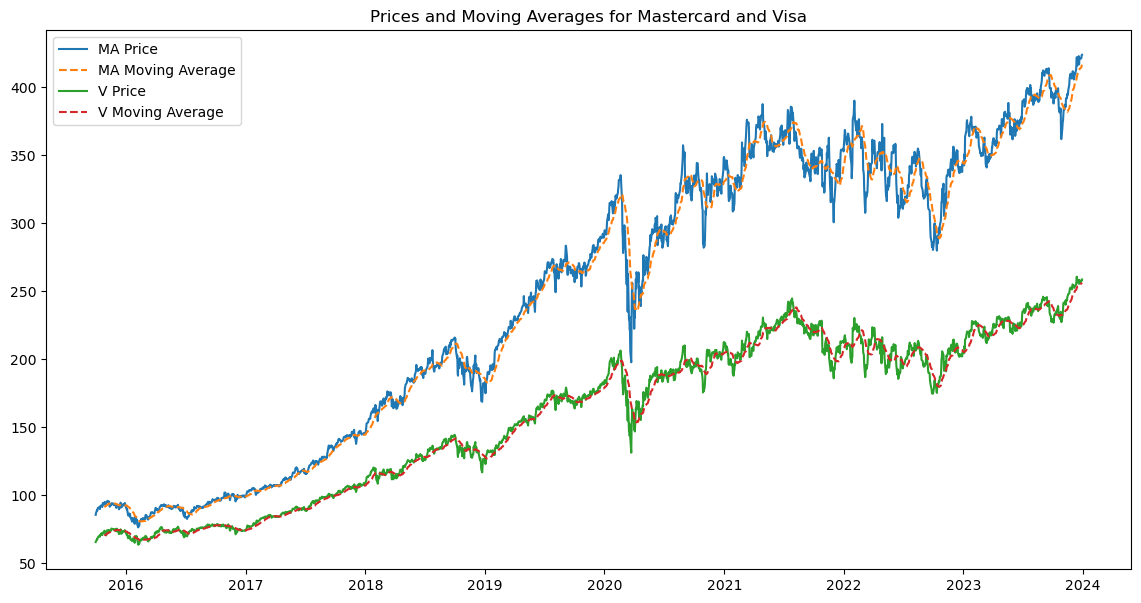

In [20]:
# Prices and Moving Averages for Mastercard and Visa
plt.figure(figsize=(14, 7))
plt.plot(stock1['Adj Close'], label='MA Price')
plt.plot(stock1['MA'], label='MA Moving Average', linestyle='--')
plt.plot(stock2['Adj Close'], label='V Price')
plt.plot(stock2['MA'], label='V Moving Average', linestyle='--')
plt.title('Prices and Moving Averages for Mastercard and Visa')
plt.legend()
plt.show()


<span style="font-size:2.2em; font-weight:bold; color:#2E86C1;">Z-Score Spread Analysis</span>

<span style="font-weight:bold;">To capture mean-reverting opportunities, we calculate the statistical spread between Mastercard and Visa and transform it into a standardized Z-score.</span>

<span style="color:#E74C3C; font-weight:bold;">1.</span> Compute the spread = Price(MA) – Price(V).  
<span style="color:#E74C3C; font-weight:bold;">2.</span> Calculate rolling mean and standard deviation of the spread.  
<span style="color:#E74C3C; font-weight:bold;">3.</span> Standardize deviations into a Z-score, highlighting moments when the spread diverges significantly from its mean.  
<span style="color:#E74C3C; font-weight:bold;">4.</span> This Z-score will later act as a trading signal trigger.  


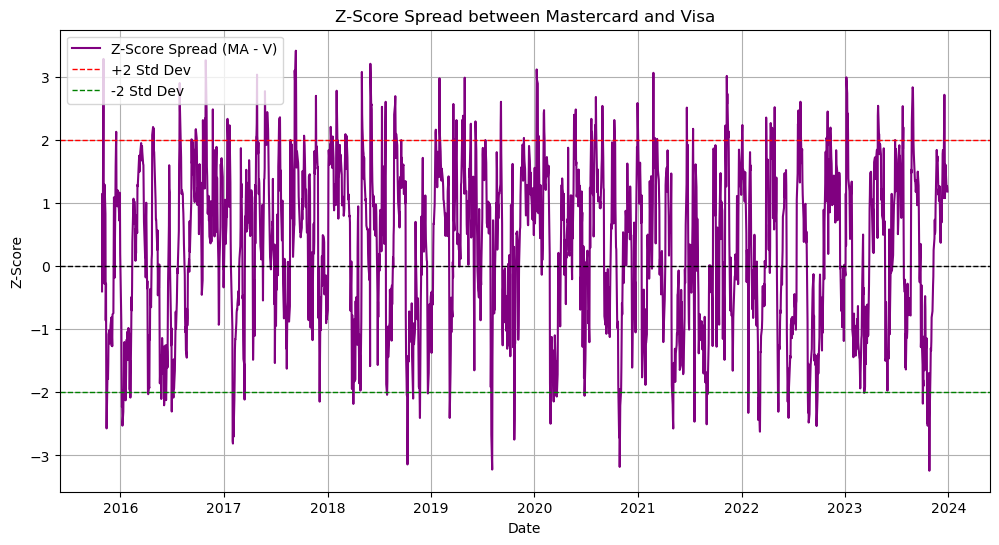

In [26]:
# Calculation of the Z-Score spread between Mastercard (MA) and Visa (V)
spread = stock1['Adj Close'] - stock2['Adj Close']  # Price difference (spread)
rolling_mean = spread.rolling(window=20).mean()     # Rolling mean over 20 days
rolling_std = spread.rolling(window=20).std()       # Rolling standard deviation over 20 days

# Calculation of the Z-Score
z_score = (spread - rolling_mean) / rolling_std

# Plot of the Z-Score spread
plt.figure(figsize=(12, 6))
plt.plot(stock1.index, z_score, label='Z-Score Spread (MA - V)', color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=1)      # Zero line
plt.axhline(2, color='red', linestyle='--', linewidth=1, label='+2 Std Dev')   # Upper threshold
plt.axhline(-2, color='green', linestyle='--', linewidth=1, label='-2 Std Dev') # Lower threshold
plt.title('Z-Score Spread between Mastercard and Visa')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True)
plt.show()


<span style="font-size:2.2em; font-weight:bold; color:#2E86C1;">ADX Trend Strength & Regime Classification</span>

<span style="font-weight:bold;">The ADX indicator is used to distinguish between trending and ranging market conditions. This is crucial because we apply different strategies depending on the regime.</span>

<span style="color:#E74C3C; font-weight:bold;">1.</span> If ADX > 25 → we assume a strong trend → apply momentum trading.  
<span style="color:#E74C3C; font-weight:bold;">2.</span> If ADX ≤ 25 → we assume weak or sideways movement → apply mean-reversion trading.  
<span style="color:#E74C3C; font-weight:bold;">3.</span> Visualizing ADX allows us to see when each strategy type becomes relevant.  


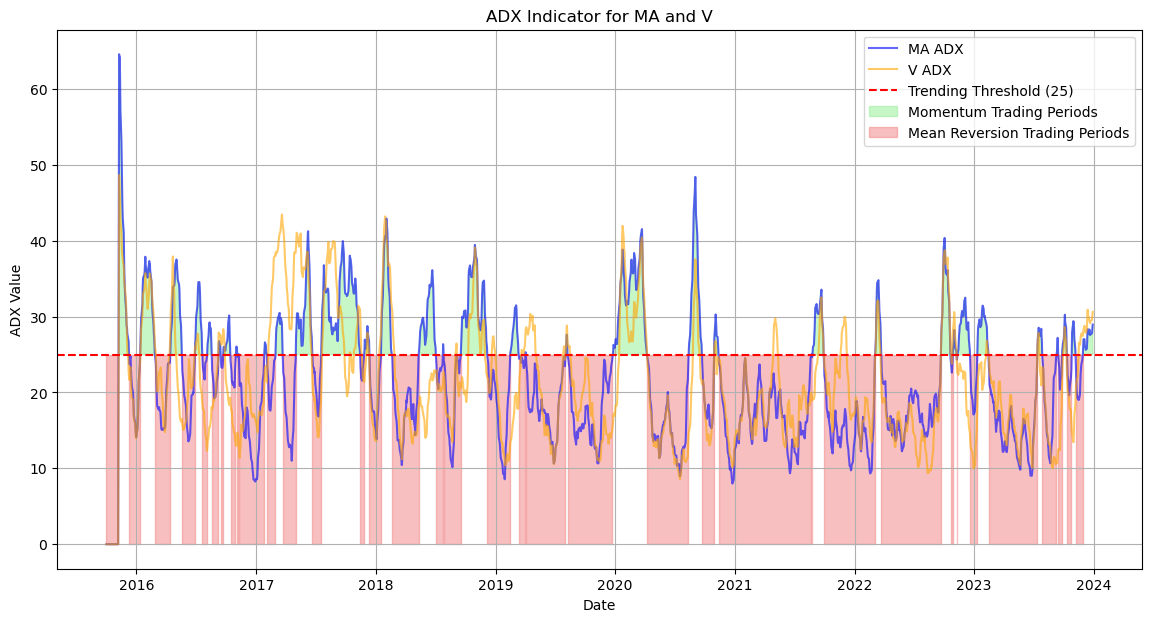

In [16]:
# Average Directional Index (ADX) for Mastercard (MA) and Visa (V) over time
plt.figure(figsize=(14, 7))
plt.plot(stock1['ADX'], label='MA ADX', color='blue', alpha=0.6)
plt.plot(stock2['ADX'], label='V ADX', color='orange', alpha=0.6)
plt.title('ADX Indicator for MA and V')
plt.xlabel('Date')
plt.ylabel('ADX Value')
plt.axhline(25, color='red', linestyle='--', label='Trending Threshold (25)')

# Highlight periods for Momentum Trading (ADX > 25)
plt.fill_between(stock1.index, 25, stock1['ADX'], where=(stock1['ADX'] > 25), 
                 color='lightgreen', alpha=0.5, label='Momentum Trading Periods')

# Highlight periods for Mean Reversion Trading (ADX <= 25)
plt.fill_between(stock1.index, 0, 25, where=(stock1['ADX'] <= 25), 
                 color='lightcoral', alpha=0.5, label='Mean Reversion Trading Periods')

plt.legend()
plt.grid()
plt.show()


<span style="font-size:2.2em; font-weight:bold; color:#2E86C1;">RSI Momentum Indicator</span>

<span style="font-weight:bold;">The Relative Strength Index (RSI) is applied to identify overbought and oversold conditions within trending markets.</span>

<span style="color:#E74C3C; font-weight:bold;">1.</span> RSI > 80 → Overbought zone → potential exit or short signal.  
<span style="color:#E74C3C; font-weight:bold;">2.</span> RSI < 20 → Oversold zone → potential entry or long signal.  
<span style="color:#E74C3C; font-weight:bold;">3.</span> This indicator is particularly useful in combination with ADX for momentum-driven pairs trading.  


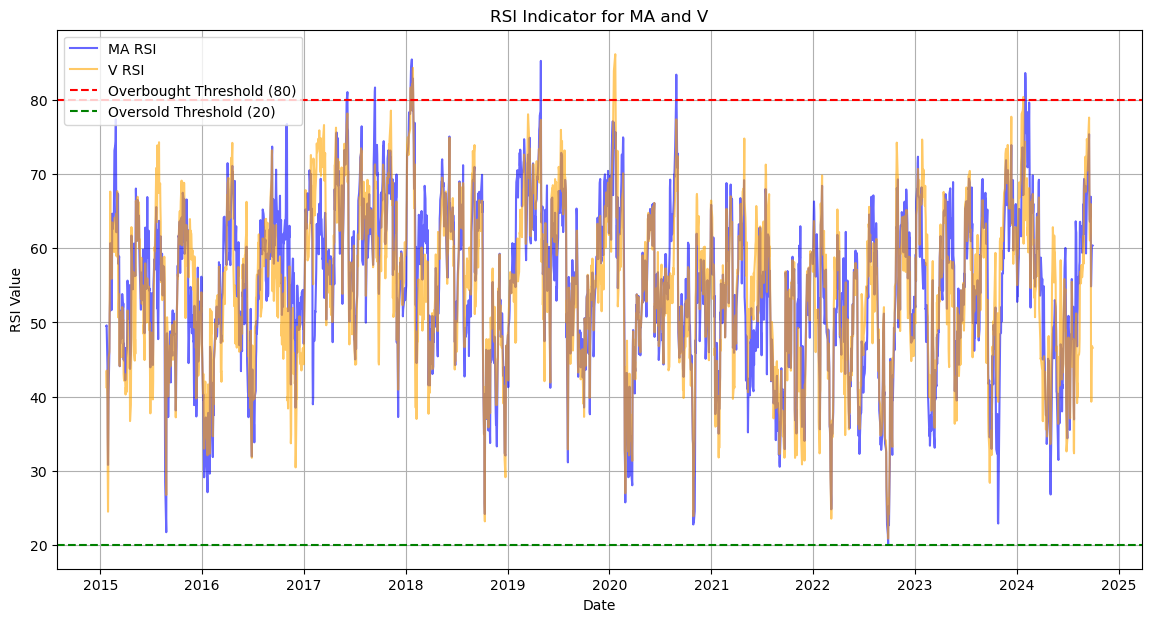

In [12]:
# Relative Strength Index (RSI) for Mastercard (MA) and Visa (V) over time, 
plt.figure(figsize=(14, 7))
plt.plot(stock1['RSI'], label='MA RSI', color='blue', alpha=0.6)
plt.plot(stock2['RSI'], label='V RSI', color='orange', alpha=0.6)
plt.title('RSI Indicator for MA and V')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.axhline(80, color='red', linestyle='--', label='Overbought Threshold (80)')
plt.axhline(20, color='green', linestyle='--', label='Oversold Threshold (20)')
plt.legend()
plt.grid()
plt.show()



<span style="font-size:2.2em; font-weight:bold; color:#2E86C1;">Trading Signal Visualization</span>

<span style="font-weight:bold;">Finally, we visualize all entry and exit signals directly on the price charts of Mastercard and Visa. This provides a clear understanding of how the strategies perform over time.</span>

<span style="color:#E74C3C; font-weight:bold;">1.</span> Momentum signals are shown when trends are strong (ADX > 25).  
<span style="color:#E74C3C; font-weight:bold;">2.</span> Mean-reversion signals are triggered when spreads diverge under low ADX regimes and high volatility.  
<span style="color:#E74C3C; font-weight:bold;">3.</span> Entry/exit markers allow us to visually confirm the logic of our strategies.  


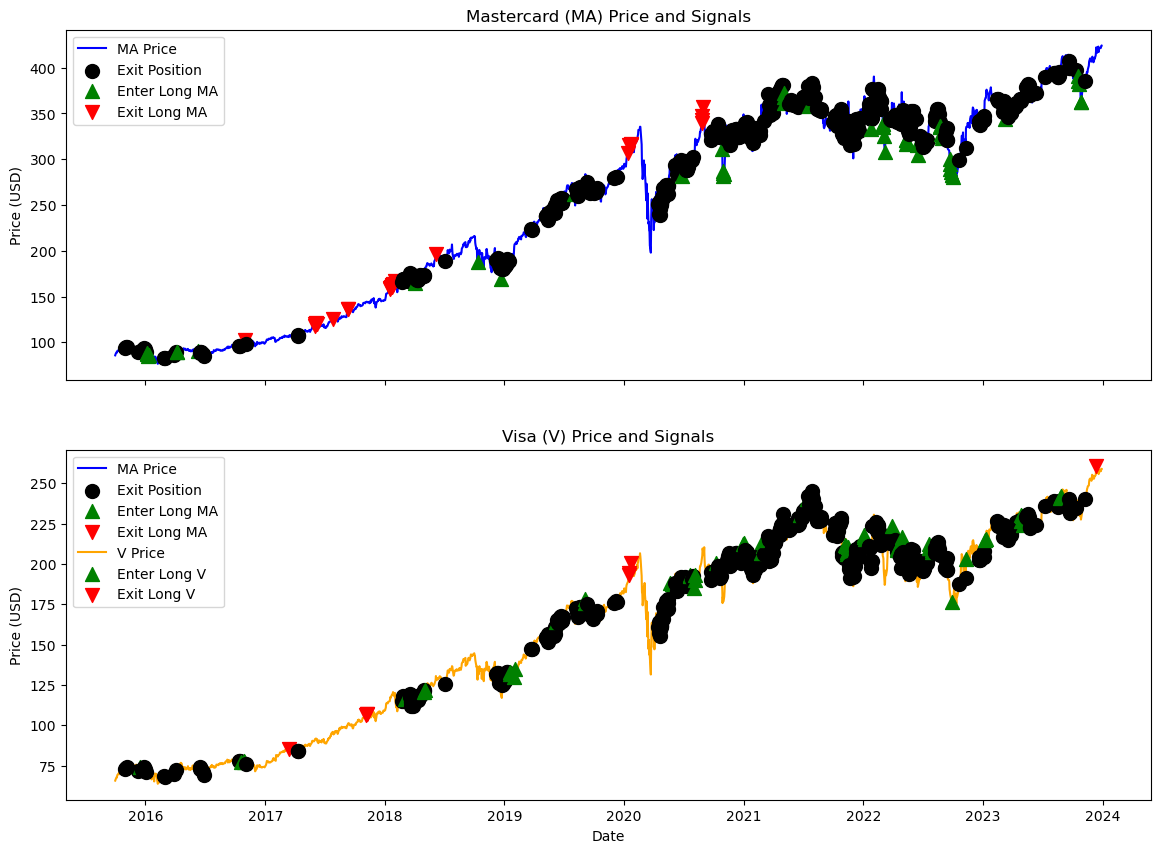

In [27]:
import matplotlib.pyplot as plt

# --- Plot Signals ---

def plot_signals(stock1, stock2, signals):
    # Erstellen eines Plots mit zwei Subplots, einen für Mastercard und einen für Visa
    fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Plot für Mastercard
    axs[0].plot(stock1['Adj Close'], label='MA Price', color='blue')
    axs[0].set_title('Mastercard (MA) Price and Signals')
    axs[0].set_ylabel('Price (USD)')

    # Plot für Visa
    axs[1].plot(stock2['Adj Close'], label='V Price', color='orange')
    axs[1].set_title('Visa (V) Price and Signals')
    axs[1].set_ylabel('Price (USD)')
    axs[1].set_xlabel('Date')

    # Hinzufügen der Signale zum Plot
    for date, action in signals:
        if 'Enter Long MA' in action:
            axs[0].scatter(date, stock1['Adj Close'].loc[date], marker='^', color='green', label='Enter Long MA', s=100, zorder=5)
        elif 'Enter Long V' in action:
            axs[1].scatter(date, stock2['Adj Close'].loc[date], marker='^', color='green', label='Enter Long V', s=100, zorder=5)
        elif 'Exit Long MA' in action:
            axs[0].scatter(date, stock1['Adj Close'].loc[date], marker='v', color='red', label='Exit Long MA', s=100, zorder=5)
        elif 'Exit Long V' in action:
            axs[1].scatter(date, stock2['Adj Close'].loc[date], marker='v', color='red', label='Exit Long V', s=100, zorder=5)
        elif 'Enter Long V, Short MA' in action:
            axs[1].scatter(date, stock2['Adj Close'].loc[date], marker='^', color='purple', label='Enter Long V, Short MA', s=100, zorder=5)
            axs[0].scatter(date, stock1['Adj Close'].loc[date], marker='v', color='purple', label='Enter Long V, Short MA', s=100, zorder=5)
        elif 'Enter Long MA, Short V' in action:
            axs[0].scatter(date, stock1['Adj Close'].loc[date], marker='^', color='purple', label='Enter Long MA, Short V', s=100, zorder=5)
            axs[1].scatter(date, stock2['Adj Close'].loc[date], marker='v', color='purple', label='Enter Long MA, Short V', s=100, zorder=5)
        elif 'Exit Position' in action:
            axs[0].scatter(date, stock1['Adj Close'].loc[date], marker='o', color='black', label='Exit Position', s=100, zorder=5)
            axs[1].scatter(date, stock2['Adj Close'].loc[date], marker='o', color='black', label='Exit Position', s=100, zorder=5)

    # Legende konfigurieren, um doppelte Labels zu vermeiden
    handles, labels = [], []
    for ax in axs:
        for h, l in zip(*ax.get_legend_handles_labels()):
            if l not in labels:
                handles.append(h)
                labels.append(l)
        ax.legend(handles, labels, loc='upper left')

    plt.show()

# Beispiel-Aufruf für die Funktion mit generierten Signalen
final_signals = momentum_pair_trading(stock1, stock2, 75, 25) + mean_reversion_pair_trading(stock1, stock2, 15)
final_signals = sorted(final_signals, key=lambda x: x[0])
plot_signals(stock1, stock2, final_signals)
